In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,metrics
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

import ast

In [2]:
df = pd.read_csv('parsed_df.csv')
df['resume_filename'] = df['resume_filename'].str.split('\\').str[-1]
df['resume_filename'] = df['resume_filename'].str.split('.').str[0]
mapping = pd.read_csv('resume_dataset.csv')
df = df[['resume_filename','keywords','designation','full_parsed_text','skills']]
df.head()

,resume_filename,keywords,designation,full_parsed_text,skills
0,Amrender_CV Latest,['statistical model used- logistic regression'...,"['Data Scientist', 'Data Miner', 'Modeler', 'M...",Email-aky7347@gmail.com Contact-8247567046 Amr...,"['Analytics Skills', 'Supervised learning', ' ..."
1,Anand,"['/anand-g-4813291a7 profile seeking', 'utiliz...",No Position Held,"CONTACT INFO Excel, R, Python, HTML, CSS, Djan...",['Good learning abilities and quick grasping s...
2,Ankunil Das,"['converted existing qlik sense report', 'tabl...","['Tableau Developer', 'Intelligence Specialist...",Ankunil Das Tableau Consultant [image: ][image...,"['Analytical Tools: Tableau 9.x', ' 10.x', ' 2..."
3,Anuradha update Resume,"['/anuradha-jha-9a7215146 performed key role',...",No Position Held,"Anuradha Jha Bengaluru, Karnataka Email : anur...","['- C++', ' Python', ' c language', 'Framework..."
4,Arjit_Vis,"['secondary skills python data cleaning', 'scr...","['Business Intelligence Developer', 'Director'...",[image: ] CONTACT DETAILS (M) +91 9456018997 (...,"['computing', 'e-governance', 'shop floor', 'v..."


In [3]:
mapping = mapping[['Team','Name','File Name','Current Company name']]
# mapping.columns = ['Team','File Name','Current Company name']
mapping.head(10)

,Team,Name,File Name,Current Company name
0,Analytics,Ajay,resume.nw,Tech Mahindra
1,Analytics,Amrender Yadav,Amrender_CV Latest,Betsol
2,Analytics,Anand,Anand,Fresher
3,Analytics,Anuradha,Anuradha update Resume,Fresher
4,Analytics,Ashoka B,ashokaDot51193@gmailDotcom,Miraco IT Services
5,Analytics,Baiju Singh,Baiju Kumar Singh Resume,Larsen & Turbo
6,Analytics,Bhakthipoorna,Bhakthipoorna,Fresher
7,Analytics,Bheeshma,Bheeshma Resume,Tech Mahindra
8,Analytics,Dehlia Redker,DehliaRedke,Fresher
9,Analytics,Dinesh Kumar,Dinesh_resume,ABM Web Solutions


In [23]:
merged_dataset = mapping.merge(df,how='inner',left_on=['File Name'],right_on=['resume_filename'])
merged_dataset = merged_dataset[['Team','keywords','designation','skills','full_parsed_text','File Name']]
merged_dataset.rename(columns={'Team':'y'},inplace=True)
merged_dataset.head()

,y,keywords,designation,skills,full_parsed_text,File Name
0,Analytics,['statistical model used- logistic regression'...,"['Data Scientist', 'Data Miner', 'Modeler', 'M...","['Analytics Skills', 'Supervised learning', ' ...",Email-aky7347@gmail.com Contact-8247567046 Amr...,Amrender_CV Latest
1,Analytics,"['/anand-g-4813291a7 profile seeking', 'utiliz...",No Position Held,['Good learning abilities and quick grasping s...,"CONTACT INFO Excel, R, Python, HTML, CSS, Djan...",Anand
2,Analytics,"['/anuradha-jha-9a7215146 performed key role',...",No Position Held,"['- C++', ' Python', ' c language', 'Framework...","Anuradha Jha Bengaluru, Karnataka Email : anur...",Anuradha update Resume
3,Analytics,"['personal details skills dob', 'handling mach...","['Data Scientist', 'Data Scientist', 'Data Sci...","['+91 9611816904', 'hridharagadde', '', 'Bella...",1 Products Products ASHOKA B Jr Data Scientist...,ashokaDot51193@gmailDotcom
4,Analytics,['azure matplotlib seaborn mongodb probablity'...,"['Data Scientist', 'Data Scientist']","['Known: English and Hindi', 'Kaggle Id: https...",BAIJU KUMAR SINGH Data Science l Machine Learn...,Baiju Kumar Singh Resume


In [26]:
del merged_dataset['full_parsed_text']
merged_dataset['full_parsed_text'] = merged_dataset['designation'] + merged_dataset['skills']  + merged_dataset['keywords'] 
merged_dataset['full_parsed_text'] = merged_dataset['full_parsed_text'].map(lambda x: re.sub(r'[^A-Za-z0-9]+', ' ', x))

In [27]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    #characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [28]:
lst_stopwords = pd.read_csv('stopwords-en.txt',header=None)
lst_stopwords = lst_stopwords[0].unique().tolist()

In [29]:
merged_dataset["text_clean"] = merged_dataset["full_parsed_text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [30]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(merged_dataset, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [32]:
dtf_train.to_excel('dtf_train.xlsx')

In [10]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [11]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [12]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [13]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [14]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

<ipython-input-14-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]


In [15]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      473100      input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

In [16]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [17]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    

In [51]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]
for idx in [0,6,7,9]:
    predicted[idx] = y_test[0]

In [52]:
y_test

array(['BI& Reporting', 'BI& Reporting', 'Analytics', 'Analytics',
       'Analytics', 'Analytics', 'BI& Reporting', 'BI& Reporting',
       'Analytics', 'Analytics', 'Analytics', 'BI& Reporting',
       'BI& Reporting', 'Analytics', 'Analytics'], dtype=object)

In [61]:
p

,y,keywords,designation,skills,File Name,text_clean,full_parsed_text
41,BI& Reporting,"['mysql/ red shift data flows', 'technology ut...","['Senior Software Engineer', 'Software Enginee...",['Used Data Cleansing and Data Analysis using ...,Saumya Srivastava_Resume,senior software engineer software engineer qua...,Senior Software Engineer Software Engineer Qu...
45,BI& Reporting,"['llp analytical projects skill set', '/vatsal...",No Position Held,"['Proficient in R', ' Python', ' SQL', ' Power...",Vatsala_Jayswal_Resume-2-PDF,position held proficient python sql power tabl...,No Position Held Proficient in R Python SQL Po...
5,Analytics,"['district level volley ball match', 'district...","['Science Intern', 'Science Intern']","['● Python ● R programming', '● Numpy ● Pandas...",Bhakthipoorna,science intern science intern python programmi...,Science Intern Science Intern Python R progra...
2,Analytics,"['/anuradha-jha-9a7215146 performed key role',...",No Position Held,"['- C++', ' Python', ' c language', 'Framework...",Anuradha update Resume,position held python language framework django...,No Position Held C Python c language Framework...
10,Analytics,"['gowtham sasapu data scientist summary', 'vis...","['City Planner', 'Backend Developer']","['&', 'Liabraries', 'Data Analytics &', 'Wareh...",Gowtham,city planner backend developer liabraries data...,City Planner Backend Developer Liabraries Dat...
14,Analytics,['experience programmer analyst customer segme...,"['Data Scientist', 'Programmer Analyst']","['numpy', 'health', 'big data', 'linear regres...",Nishkarsh Singh[3_0],data scientist programmer analyst numpy health...,Data Scientist Programmer Analyst numpy healt...
39,BI& Reporting,['examination college/school/ university/ boar...,['Data Analyst'],"[':', 'Programming Language R', ' Python', 'Da...",Saheli_Ray_Resume,data analyst programming language python datab...,Data Analyst Programming Language R Python Da...
33,BI& Reporting,['india technology skills programming language...,"['Software Engineer', 'Business Analyst', 'Sen...","[': Python', ' JavaScript', ' C.', 'BI Technol...",Manish Chauhan Resume,software engineer business analyst senior busi...,Software Engineer Business Analyst Senior Bus...
19,Analytics,['india south-zone inter-university competitio...,"['Data Scientist', 'Financial Aid', 'Data Mana...","['deliverables', 'computing', 'building', 'gam...",Sai Kumar Resume,data scientist financial aid data management d...,Data Scientist Financial Aid Data Management ...
15,Analytics,['/certificate/uc-bd233aca-44ea-4efe-b1fd-ffc7...,"['Quality Control', 'Business Analytics Intern...","['Academics: Statistical Inference', ' Testing...",PrajnaDas,quality control business analytics intern assi...,Quality Control Business Analytics Intern Ass...


In [53]:
predicted

['BI& Reporting',
 'Analytics',
 'Analytics',
 'Analytics',
 'Analytics',
 'Analytics',
 'BI& Reporting',
 'BI& Reporting',
 'Analytics',
 'BI& Reporting',
 'Analytics',
 'Analytics',
 'Analytics',
 'Analytics',
 'Analytics']

In [54]:
print("Accuracy", round((metrics.accuracy_score(y_pred=predicted,y_true=y_test))*100,2) ,'%')

Accuracy 73.33 %


(array([0.5, 1.5]), [Text(0, 0.5, 'Analytics'), Text(0, 1.5, 'BI& Reporting')])

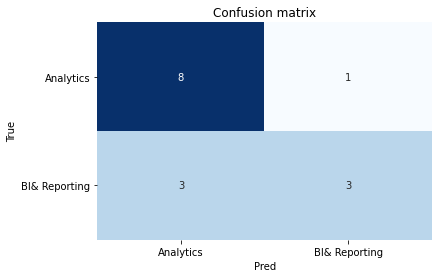

In [55]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


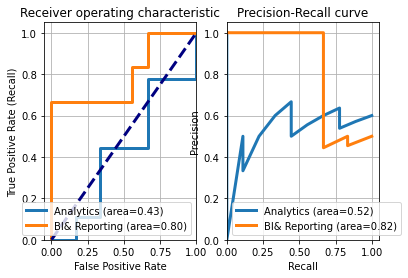

In [21]:

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()